In [46]:
import tensorflow as tf
import os

In [47]:
# Avoid OOM (out of memory error) errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [48]:
#Clean the data
import cv2
from PIL import Image

In [49]:
# get the extension of the image
def get_image_extension(file_path):
    root, extension = os.path.splitext(file_path)
    return extension.lower() 

In [50]:
data_dir = 'data'

In [51]:
image_exts = ['.jpeg','.jpg', '.bmp', '.png']

In [52]:
#clean images
for img_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, img_class)):
        image_path = os.path.join(data_dir, img_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = get_image_extension(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))

In [53]:
import numpy as np
from matplotlib import pyplot as plt

In [54]:
#load data
# the image_dataset_from_directory function scans the 'data' directory and its subdirectories. 
#It assumes that each subdirectory represents a different class, and the images within those subdirectories belong to those respective classes. 
#The function loads these images, resizes them to a consistent size (default is 256x256 pixels), and organizes them into batches. 
#It also performs shuffling and prefetching to optimize data loading during training.
data = tf.keras.utils.image_dataset_from_directory('data')

Found 171 files belonging to 2 classes.


In [12]:
#we're going to create a python eterator from the tensorflow dataset
#as_numpy_iterator() is a method available for TensorFlow datasets. 
#When called, it returns an iterator that yields batches of data from the dataset, with each batch represented as a NumPy array.
data_iterator = data.as_numpy_iterator()

In [13]:
batch = data_iterator.next()
#batch[0] contains the images
#batch[1] contains the labels
#class 0 = happy people
#class 1 = sad people

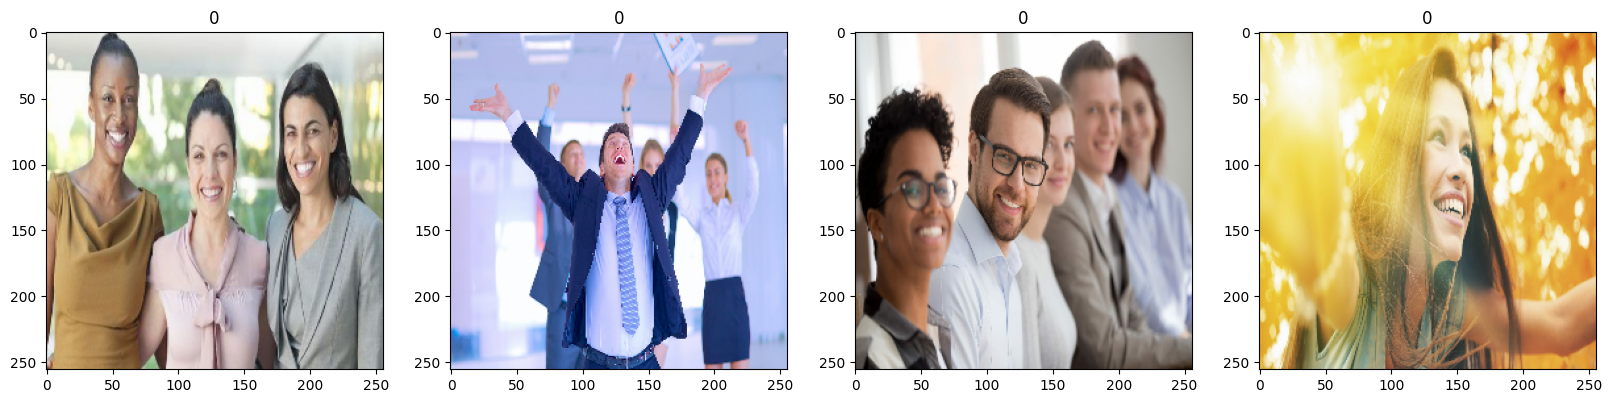

In [14]:
#we'll display the 4 first images and above them we'll put their labels
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

In [55]:
#Scale our data
data = data.map(lambda x,y:(x / 255, y))

In [56]:
#split the data
len(data)
train_size = int(len(data)*.7)  #the size of data we'll use to train our model
val_size = int(len(data)*.2)  #The size of data we'll use to evaluate our model
test_size = int(len(data)*.1) + 1   #This dat won't be used until the end (the model shouldn't this data)

train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

In [57]:
#Build the deep learning model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
#Sequential is a linear stack of layers for building neural networks in Keras
#Conv2D is a 2D convolutional layer. It is used for spatial convolution over images.
#Max pooling reduces the dimensionality of each feature map while retaining the most important information
#In a dense layer, every node (or neuron) is connected to every node in the previous layer. It is used for tasks where each input node needs to be connected to each output node.
#Flatten converts multi-dimensional data (like feature maps) into a one-dimensional vector. 
#Dropout is a regularization technique where randomly selected neurons are ignored during training.

In [58]:
model = Sequential()

In [59]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [60]:
#applying the adam optemizer
#Optimizers are algorithms or methods used to minimize this loss function by updating the model's parameters iteratively
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [61]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 30, 30, 16)       

In [64]:
#Train the model
#Create a log directory 
logdir='logs'

In [65]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [66]:
#we will apply the fit component to train our model
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
4/4 [==============================] - 17s 2s/step - loss: 1.7164 - accuracy: 0.5078 - val_loss: 1.2675 - val_accuracy: 0.3125
Epoch 2/20
4/4 [==============================] - 11s 2s/step - loss: 0.7502 - accuracy: 0.5625 - val_loss: 0.6137 - val_accuracy: 0.6250
Epoch 3/20
4/4 [==============================] - 10s 2s/step - loss: 0.6182 - accuracy: 0.6094 - val_loss: 0.5930 - val_accuracy: 0.6250
Epoch 4/20
4/4 [==============================] - 11s 2s/step - loss: 0.6123 - accuracy: 0.5781 - val_loss: 0.6458 - val_accuracy: 0.5938
Epoch 5/20
4/4 [==============================] - 12s 2s/step - loss: 0.5417 - accuracy: 0.6797 - val_loss: 0.5259 - val_accuracy: 0.6562
Epoch 6/20
4/4 [==============================] - 12s 2s/step - loss: 0.5049 - accuracy: 0.7812 - val_loss: 0.4424 - val_accuracy: 0.7188
Epoch 7/20
4/4 [==============================] - 12s 2s/step - loss: 0.4691 - accuracy: 0.7734 - val_loss: 0.3907 - val_accuracy: 0.9062
Epoch 8/20
4/4 [==================

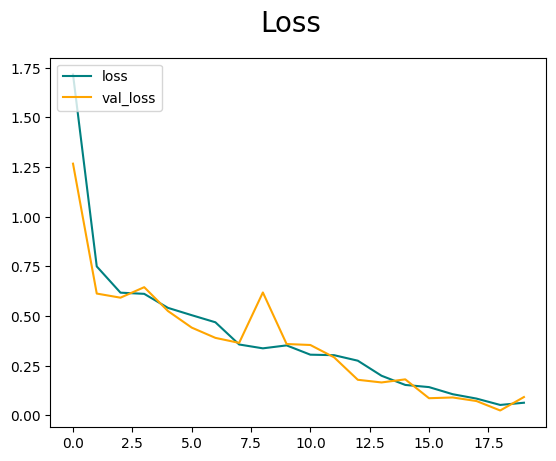

In [67]:
#Let's plot the performance 
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

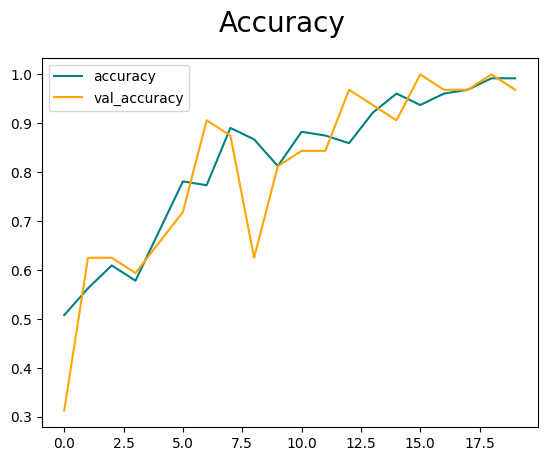

In [68]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [69]:
#Evaluate the performance
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [70]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [71]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 [==============================] - 0s 395ms/step


In [73]:
print(f'Precision: {pre.result().numpy()}, Recall: {re.result().numpy()},  Accuracy: {acc.result().numpy()}')

Precision: 1.0, Recall: 1.0,  Accuracy: 1.0


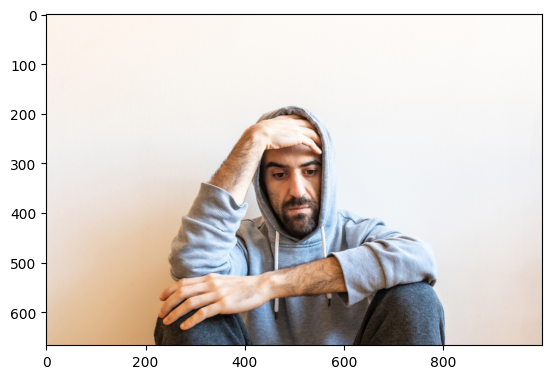

In [84]:
#Test
img = cv2.imread('sadTest.jpg')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

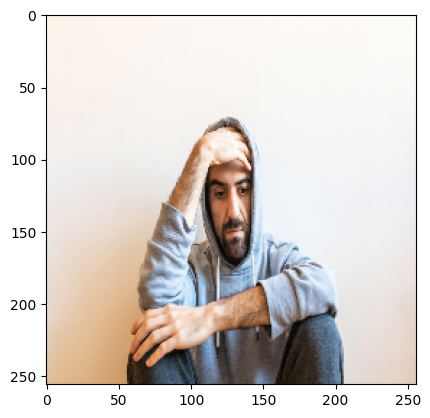

In [85]:
resize = tf.image.resize(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [86]:
#we need to expand the dimension because the neural network model expects to go through a batch of images not a single image
yhat = model.predict(np.expand_dims(resize/255, 0))
yhat

1/1 [==============================] - 0s 90ms/step


array([[0.73699725]], dtype=float32)

In [87]:
if yhat > 0.5: 
    print(f'Predicted class is Sad')
else:
    print(f'Predicted class is Happy')

Predicted class is Sad


In [88]:
#save the model
from tensorflow.keras.models import load_model

In [90]:
#We serialize the model
model.save(os.path.join('models', 'binaryimageclassifier.keras'))

In [92]:
#Let reload the model
new_model = load_model(os.path.join('models', 'binaryimageclassifier.keras'))

In [93]:
new_model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 285ms/step


array([[0.73699725]], dtype=float32)